## Отчет по лабораторной работе №3

Параметры ноутбука исследовались с помощью программы CPU-Z.

Скрины [CPU](cpu-z-screens/specs_02_CPU.png), [Cache](cpu-z-screens/specs_01_Caches.png) показывают характеристики CPU и его кэша. Параметры остальных частей системы можно посмотреть в папке [cpu-z-screens](cpu-z-screens).

![CPU](cpu-z-screens/specs_02_CPU.png)
![Cache](cpu-z-screens/specs_01_Caches.png)

Код для анализа количества промахов находится в файлах [Cache.h](Cache.h) и [main_analyzed.cpp](main_analyzed.cpp). Компиляция производится с помощью скрипта [compile.sh](compile.sh). Получаем программу cache_analyzed, которая на вход получает следующие аргументы:
1. размер матрицы
+  размер кэша в байтах
+  ассоциативность кэша
+  размер кэш линии в байтах
+  стратегия вытеснения из кэша (0 - LRU, 1 - вытеснение произовльной линии)

Тестирование производилось с помощью скрипта [run_tests.sh](run_tests.sh) для точек 1023, 1024, 1025, 1040, 1041, 1050, 1100; получены следующие файлы с результатами:
* cache\_analyzer\_lru\_*.log - для результатов работы написанного анализатора кэша со стратегией вытеснения LRU
* cache\_analyzer\_random\_*.log - для результатов работы написанного анализатора кэша со стратегией вытеснения произвольной линии
* valgrind_*.log - для результатов работы valgrind


Исследования проводились для двух вариантов:
1. использовались характеристики компьютера (размер кэш-линии - 6291456 = 6 Mb, ассоциативность - 12, кэш-линия - 64 байта)
+  использовались кастомные характеристики (размер кэш-линии - 3145728 = 3 Mb, ассоциативность - 12, кэш-линия - 64 байта)

Первый вариант соответствует результатам с постфиксом 6mb, второй - 3mb.

Представим результаты на графиках.

In [5]:
%matplotlib inline
import matplotlib.pyplot as pyplot

def draw_results(postfix):
    
    tests = []
    touches = [[], [], []]
    misses = [[], [], []]
    rates = [[], [], []]
    
    names = ["cache_analyzer_lru_", "cache_analyzer_random_"]
    for i in xrange(0, 2):
        with open(names[i] + postfix + ".log") as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith("n = ") and i != 0:
                    tests.append(int(line.split("=")[1]))
                elif line.startswith("Cache touches : "):
                    touches[i].append(int(line.split(":")[1]))
                elif line.startswith("Cache misses : "):
                    misses[i].append(int(line.split(":")[1]))
                elif line.startswith("Cache miss ratio : "):
                    rates[i].append(float(line.split(":")[1]) * 100)
                    
    with open("valgrind_" + postfix + ".log") as f:
        lines = f.readlines()
        for line in lines:
            if "D   refs:" in line:
                touches[2].append(int(line.split(":")[1].split("(")[0].replace(",", "")))
            elif "LLd misses:" in line:
                misses[2].append(int(line.split(":")[1].split("(")[0].replace(",", "")))
            elif "LLd miss rate:" in line:
                rates[2].append(float(line.split(":")[1].split("(")[0].replace("%", "")))
           
    def draw_plot(x_list, y_list, title, ylabel = "count"):
        labels = ["LRU", "Random", "Valgrind"]
        lsl = ['-.', ':', ':']
        fig = pyplot.figure(figsize=(17,5), dpi=90)
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        for i in xrange(0, 3):
            ax.plot(x_list, y_list[i], label = labels[i], ls=lsl[i], lw=3, marker='o', markersize=4)
        ax.legend(loc='upper left')

        pyplot.xticks([1024, 1040, 1050, 1100])
        pyplot.xlabel('size')
        pyplot.ylabel(ylabel)
        pyplot.show()
    
    draw_plot(tests, touches, "Total refs")
    draw_plot(tests, misses, "Misses")
    draw_plot(tests, rates, "Miss rate", "rate, %")

Сначала рассмотрим результаты для характеристик компьютера.

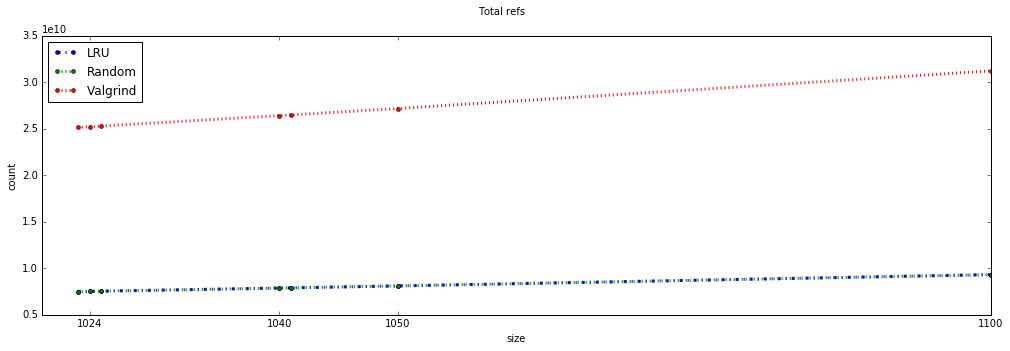

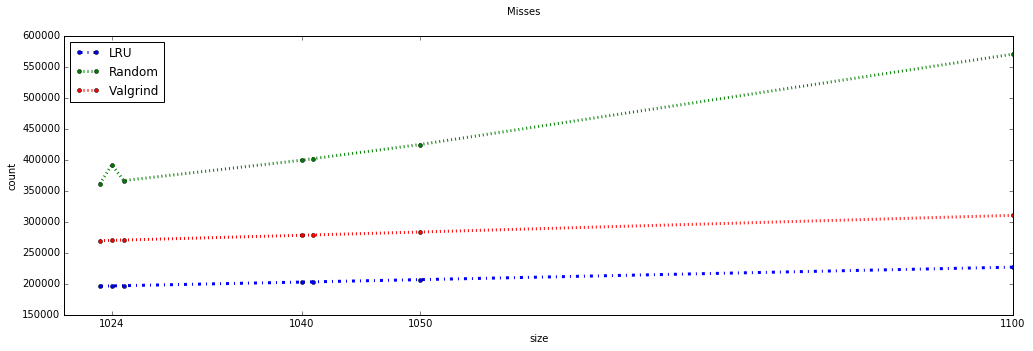

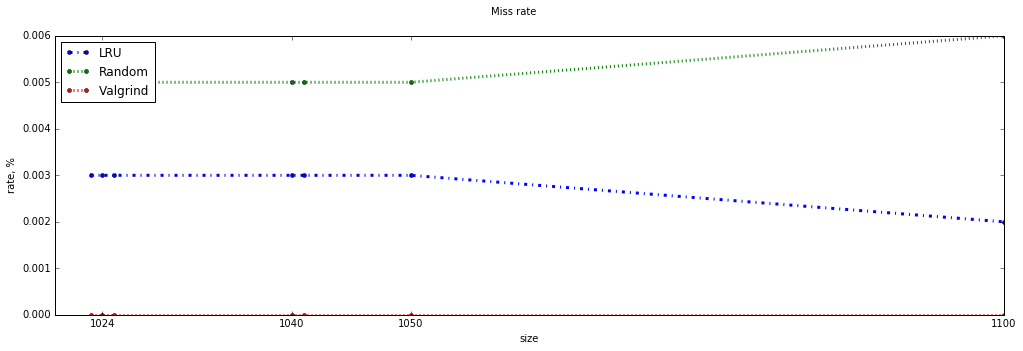

In [6]:
draw_results("6mb")

#### Выводы:
* по первому графику можно сделать вывод, что valgrind учитывает на порядок больше обращений к памяти, чем мой анализатор;
* по второму графику - что для данных характеристик стратегия вытеснения произвольного элемента работает хуже, чем стратегия LRU;
* третий дал до конца не ясные результаты, так как ни valgrind, ни мой анализатор не обнаружил серьезных проблем с кэш-промахами в точке 1024, хотя эксперименты, проведенные в первой лабораторной работе говорят о том, что время работы алгоритма в точке 1024 в среднем в 2 раза хуже чем в точках 1023 и 1025; у меня есть два предположения на этот счет: 
        1. возможно, проблема в том, что мы не учитываем кэш второго уровня и для такого большого кэша третьего уровня это является решающим фактором
        2. возможно у процессора есть особенный алгоритм распределения использования кэша третьего уровня между программами из-за чего, когда я тестировал запуски в первой лабораторной, получал результаты, не совсем соответствующие результатам valgrind и моего анализатора

Теперь рассмотрим результаты для кастомных характеристик, описанных выше.

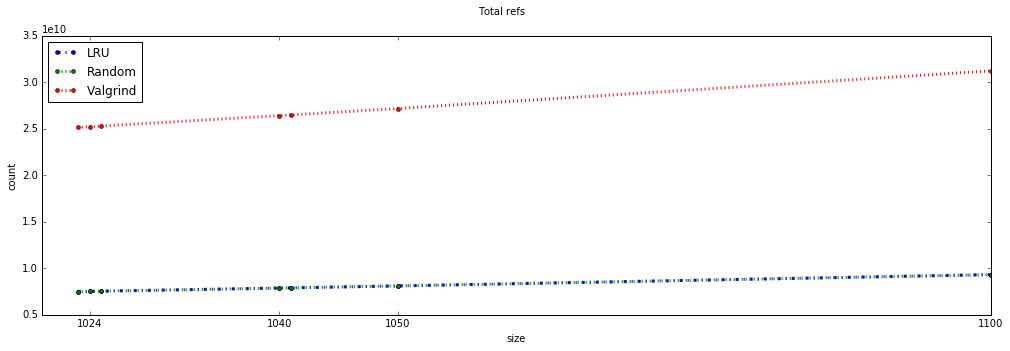

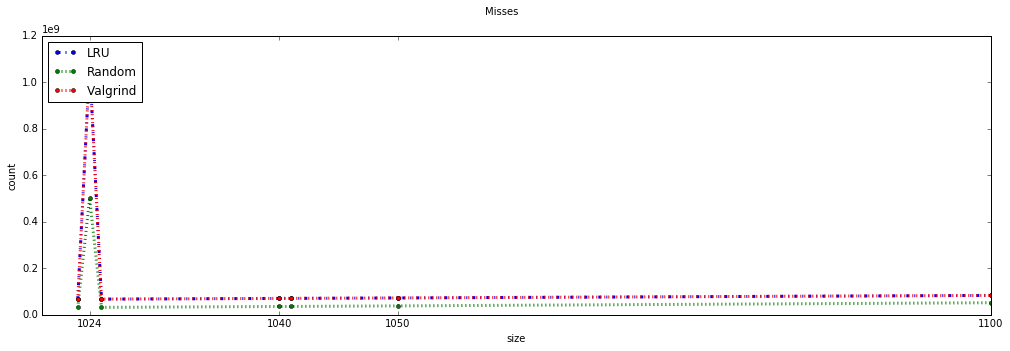

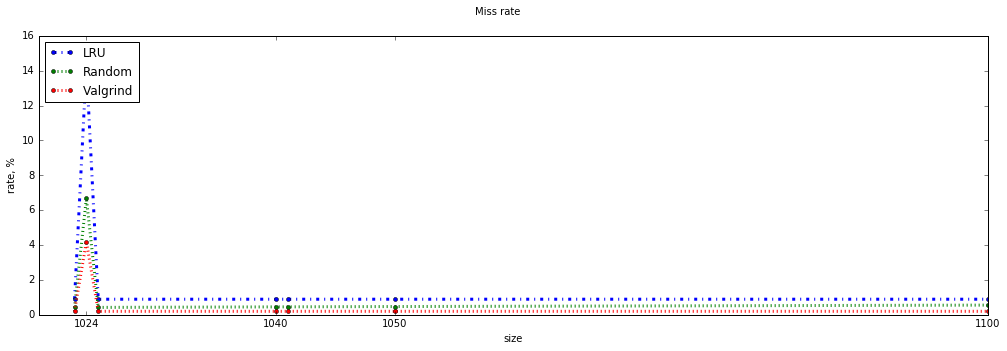

In [7]:
draw_results("3mb")

#### Выводы:
* по первому графику, как и в предыдущем пункте видно, что valgrind обнаруживает в несколько раз больше обращений к памяти;
* по второму графику видно, что valgrind и мой анализатор обнаруживают практически одинаковое количество кэш-промахов для LRU, в то время как в случае с алгоритмом вытеснения произвольной кэш-линии кол-во кэш-промахов оказывается меньше, что положительно влияет на время работы;
* по третьему графику в точке 1024 обнаруживается проблема с кол-вом кэш-промахов (она проявляется в резком скачке); в остальных же точках, которые были исследованы проблем нет.

В целом данные результаты говорят о том, что мой анализатор работает достаточно корректно, причем алгоритм произвольного вытеснения кэш-линии даёт даже лучшие результаты чем LRU.